In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


In [2]:
#setting up salary data
sal=pd.concat([pd.read_csv(f"salaries/p_{yr}.csv") for yr in range(2018,2010,-1)])
sal=sal.groupby("name").first()

In [3]:
#Setting up dataframes
eval_data = pd.read_csv("averages_enrol.csv")
eval_data[["term"]]=pd.Categorical(eval_data.term)
eval_data[["section"]]=pd.Categorical(eval_data.section)
#eval_data["response_rate"] = eval_data.num_responses / eval_data.enrolled
#df.replace([np.inf, -np.inf], np.nan)

df=eval_data[eval_data.num_resp>10] # only surveys with >10 responses
df=df.groupby("instructor").filter(lambda x:len(x)>2) # only teachers with >=3 classes
df=pd.merge(df,sal,how='left', left_on=["instructor"],right_on=['name']).drop(['benefits',"section"],axis=1)
df.title.replace(np.nan,"Lecturer",inplace=True)

In [4]:
df_tenure=df.groupby("instructor").mean()
df_tenure["num_taught"]=df.groupby("instructor").size()
df_tenure["title"]=df.groupby("instructor").first()[["title"]]
has_tenure=df_tenure.title.isin(["Professor","Associate Professor"])
titles = df_tenure.title

In [5]:
titles.replace("Lecturer",0,inplace=True)
titles.replace("Assistant Professor",1,inplace=True)
titles.replace("Associate Professor",2,inplace=True)
titles.replace("Professor",3,inplace=True)
titles

instructor
Adam Kolkiewicz        2
Adam Roegiest          0
Adriel Dean-Hall       0
Ahmad Alrefai          0
Ahmed Ayaz Ataullah    0
                      ..
Yongqiang Zhao         0
Yu-Ru Liu              3
Yuying Li              3
Zoran Miskovic         3
shahla Aliakbari       0
Name: title, Length: 352, dtype: int64

# Classifiers
The data was fit onto many different classifiers to take a look at how the classifiers performed and also look at the how the underlying data affects different classifiers. In this project, the classification is a component of the analysis, not the final product of the analysis. 

Classifiers were not picked due to any pattern, but follow the ones introduced in Stat 441. We start with K-Nearest Neighbours, a support vector machine classifier, several tree and boosting methods (Decision tree, Random Forest, Adaboost, XGBoost), followed by some more basic classifiers (Naive Bayes, LDA, QDA, and Logistic Regression)

For a select set of the classifiers (SVC,Random Forest, Decision Tree, XGBoost) 5-fold cross validation grid/random search was used to tune the hyperparameters. The others were left as is using certain default methods as they have relatively few parameters.

Grid search was used to tune the SVC due to the different number of parameters depending on kernel, and random search for the rest. 

In [6]:
#grid search for parameter selection of certain estimators
## SVC grid search
param_grid_SVC = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
 ]

SVC_clf = GridSearchCV(SVC(), param_grid_SVC, cv=5,iid=False)

#RF
param_grid_RF =  {'bootstrap': [True, False],
 'max_depth':[10,20,30,40,50],
 'max_features':['auto',None],
 'min_samples_leaf': [1,2,3],
 'min_samples_split': [2,5,10],
 'n_estimators': [200,400,800,1000]}

RF_clf = RandomizedSearchCV(RandomForestClassifier(),param_grid_RF,cv=5,iid=False)

param_grid_DT =  {'criterion': ['gini','entropy'],
  'splitter': ['best','random'],
 'max_depth': [10,20,30,40,50],
 'max_features': ['auto'],
 'min_samples_leaf': [2],
 'min_samples_split': [3]}

DT_clf = RandomizedSearchCV(DecisionTreeClassifier(),param_grid_DT,cv=5,iid=False)

param_grid_xgb = {
    'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8],
    'gamma': [0,1,5],
    'learning_rate': [0.1, 0.05, 0.01],
    'maxdepth': [3],
    'n_estimators': [500]
}

XGB_clf = RandomizedSearchCV(xgb.XGBClassifier(),param_grid_xgb,cv=5,iid=False)


In [37]:
#preparing feats
feats=list(df_tenure.select_dtypes('number').columns)
feats.remove("salary")
feats.remove("title")

#scale data
#standardize the data
X= df_tenure
X=StandardScaler().fit_transform(X[feats])

print(feats)

#set up of names and classifiers 
names = ["Nearest Neighbors", "SVM tuned",
         "Decision Tree", "Random Forest","AdaBoost","XGB",
         "Naive Bayes","LDA","QDA","LogReg"]

classifiers = [
    
    KNeighborsClassifier(10),
    SVC_clf,
    DT_clf,
    RF_clf,
    AdaBoostClassifier(),
    XGB_clf,
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear')]

['org', 'expl_lvl', 'q_treat', 'visual', 'oral', 'help', 'interest', 'overall', 'attend', 'assign', 'notes', 'textbook', 'new_mat', 'assign_amt', 'outside', 'num_resp', 'enrolled', 'resp_rate', 'num_taught']


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,has_tenure,test_size=0.3,random_state=42)

output = pd.DataFrame(index = ['train_error', 'base_line_train', 'test_error','base_line_test', 'score']) 

for name,classifier in zip(names,classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err, baseline_train, test_err,baseline_test, score]
    output[f"{name}"] = output_l
print(output)


### table of errors of different classifiers 

                 Nearest Neighbors  SVM tuned  Decision Tree  Random Forest  \
train_error               0.247967   0.186992       0.142276       0.052846   
base_line_train           0.406504   0.406504       0.406504       0.406504   
test_error                0.283019   0.264151       0.358491       0.292453   
base_line_test            0.462264   0.462264       0.462264       0.462264   
score                     0.716981   0.735849       0.641509       0.707547   

                 AdaBoost       XGB  Naive Bayes       LDA       QDA    LogReg  
train_error      0.044715  0.158537     0.304878  0.223577  0.134146  0.215447  
base_line_train  0.406504  0.406504     0.406504  0.406504  0.406504  0.406504  
test_error       0.339623  0.330189     0.330189  0.273585  0.264151  0.301887  
base_line_test   0.462264  0.462264     0.462264  0.462264  0.462264  0.462264  
score            0.660377  0.669811     0.669811  0.726415  0.735849  0.698113  


In [61]:
#getting coefficient values from logistic regression, descending by absolute value
coefs = pd.DataFrame(columns = [0,1])
for feat,coef in sorted(zip(feats,classifier.coef_[0]),key=lambda x:abs(x[1]),reverse=True):
        temp = pd.DataFrame([feat,coef])
        coefs = coefs.append(temp.transpose())
print(coefs)

            0          1
0    expl_lvl    1.06493
0     overall   0.795608
0   resp_rate  -0.593544
0  assign_amt  -0.567668
0     q_treat  -0.545886
0     new_mat  -0.508964
0    num_resp   0.464125
0         org  -0.396151
0  num_taught   0.384893
0     outside  -0.339386
0    interest   0.318795
0      visual   0.299261
0    textbook   0.297674
0        help  -0.275634
0      attend  -0.269953
0    enrolled  -0.253497
0        oral  -0.156156
0       notes  -0.104746
0      assign -0.0989166


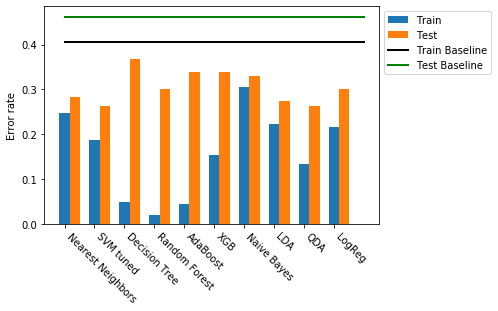

In [11]:
#plotting the above table
ind = np.arange(10)
p1 = plt.bar(ind,output.transpose().train_error,width=0.35)
p2 = plt.bar(ind+0.35,output.transpose().test_error,width=0.35)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind,output.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.legend((p1[0], p2[0],l1[0],l2[0]), ('Train', 'Test','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

Here, we can see that most of the classifiers performed similarly with test error rates between about 0.25 to 0.3. Every classifier was below their baseline. Decision tree classifier performed by far the worst out of all the classifiers and on certain runs is actually very close to the test_baseline value as seen in the plot below. The decision tree's error rates are highly variable. This is unstability is due to small differences in the randomness of the decision tree generating very different trees. The decision trees are also overfit. The most overfit classifier were the random forest classifiers, giving 0 training error. Since we are optimizing max_depth as a parameter of random forest, it will try to pick the largest one as it is more likely to provide a single value within each leaf giving the lowest error. If we are tuning parameters based on error, it might be better to not tune the max_depth value to high values to prevent overfitting.

In [62]:
#decision tree multiple runs
#look at variability of decision tree and weak learner
classifier = DT_clf
output_dt = pd.DataFrame(index = ['train_error', 'base_line_train', 'test_error','base_line_test', 'score']) 
for i in range(1,11):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err, baseline_train, test_err,baseline_test, score]
    output_dt[f"dt{i}"] = output_l
print(output_dt)

                      dt1       dt2       dt3       dt4       dt5       dt6  \
train_error      0.295455  0.073864  0.119318  0.102273  0.312500  0.107955   
base_line_train  1.193182  1.193182  1.193182  1.193182  1.193182  1.193182   
test_error       0.448864  0.482955  0.511364  0.602273  0.500000  0.488636   
base_line_test   1.181818  1.181818  1.181818  1.181818  1.181818  1.181818   
score            0.551136  0.517045  0.488636  0.397727  0.500000  0.511364   

                      dt7       dt8       dt9      dt10  
train_error      0.113636  0.232955  0.244318  0.142045  
base_line_train  1.193182  1.193182  1.193182  1.193182  
test_error       0.500000  0.511364  0.511364  0.613636  
base_line_test   1.181818  1.181818  1.181818  1.181818  
score            0.500000  0.488636  0.488636  0.386364  


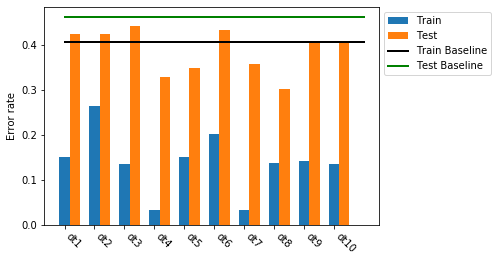

In [13]:
#plotting above table
ind = np.arange(10)
p1 = plt.bar(ind,output_dt.transpose().train_error,width=0.35)
p2 = plt.bar(ind+0.35,output_dt.transpose().test_error,width=0.35)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind,output_dt.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.legend((p1[0], p2[0],l1[0],l2[0]), ('Train', 'Test','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

In [14]:
#do the same classification as above except on PCA transformed data, keeping 0.8 of the variance
from sklearn.decomposition import PCA
X= df_tenure
X=StandardScaler().fit_transform(X[feats])
X = PCA(.80).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,has_tenure,test_size=0.3,random_state=42)

output_PCA = pd.DataFrame(index = ['train_error', 'test_error', 'base_line_train','base_line_test', 'score']) 

for name,classifier in zip(names,classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err, test_err, baseline_train,baseline_test, score]
    output_PCA[f"{name}"] = output_l
print(output_PCA)

                 Nearest Neighbors  SVM tuned  Decision Tree  Random Forest  \
train_error               0.252033   0.227642       0.170732       0.077236   
test_error                0.311321   0.330189       0.339623       0.283019   
base_line_train           0.406504   0.406504       0.406504       0.406504   
base_line_test            0.462264   0.462264       0.462264       0.462264   
score                     0.688679   0.669811       0.660377       0.716981   

                 AdaBoost       XGB  Naive Bayes       LDA       QDA    LogReg  
train_error      0.126016  0.182927     0.288618  0.272358  0.276423  0.272358  
test_error       0.292453  0.311321     0.358491  0.301887  0.349057  0.301887  
base_line_train  0.406504  0.406504     0.406504  0.406504  0.406504  0.406504  
base_line_test   0.462264  0.462264     0.462264  0.462264  0.462264  0.462264  
score            0.707547  0.688679     0.641509  0.698113  0.650943  0.698113  


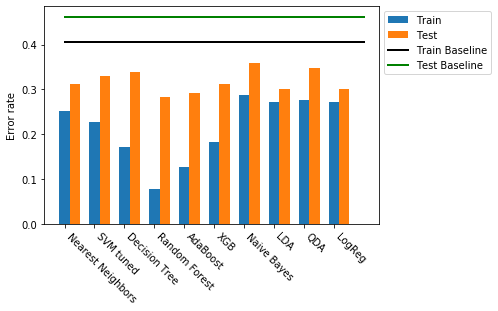

In [15]:
#plot the above table
ind = np.arange(10)
p1 = plt.bar(ind,output_PCA.transpose().train_error,width=0.35)
p2 = plt.bar(ind+0.35,output_PCA.transpose().test_error,width=0.35)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind,output_PCA.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.legend((p1[0], p2[0],l1[0],l2[0]), ('Train', 'Test','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

## Comparing classifiers with their PCA transformed counterparts

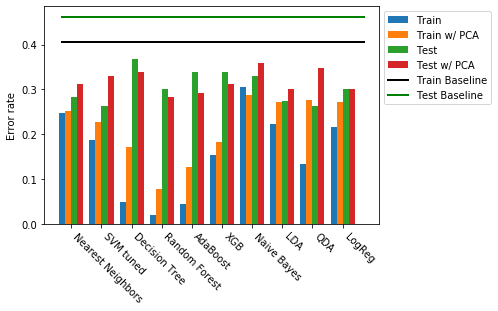

In [16]:
#plot both the PCA and non-PCA errors side by side to compare effect of PCA 
ind = np.arange(10)
wid = 0.2
p1 = plt.bar(ind,output.transpose().train_error,width=wid)
p1_PCA = plt.bar(ind+wid,output_PCA.transpose().train_error,width=wid)
p2 = plt.bar(ind+2*wid,output.transpose().test_error,width=wid)
p2_PCA = plt.bar(ind+3*wid,output_PCA.transpose().test_error,width=wid)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind+1.5*wid,output_PCA.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.legend((p1[0], p1_PCA[0],p2[0], p2_PCA[0],l1[0],l2[0]),\
           ('Train', 'Train w/ PCA','Test','Test w/ PCA','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

Most of the classifiers did not see a decrease in the test error, and some had an increase in test error. Interestingly, the two boosting algorithms managed to achieve lower test error when working with transformed PCA data vs without. 

With a plot of the two PCA components, we don't see clear separation in the data at all. Both tenure and un-tenured employees are included. This suggests that there does not exist much of a difference in the reviews of the two types of university employees. 

In [18]:
# Here we are going to classify by class instead of tenure vs no tenure

#preparing feats
feats=list(df_tenure.select_dtypes('number').columns)
feats.remove("salary")
feats.remove("title")
#scale data
#standardize the data
X= df_tenure
X=StandardScaler().fit_transform(X[feats])

print(feats)

#set up of names and classifiers 
names = ["Nearest Neighbors", "SVM tuned",
         "Decision Tree", "Random Forest","AdaBoost","XGB",
         "Naive Bayes","LDA","QDA","LogReg"]

classifiers = [
    
    KNeighborsClassifier(10),
    SVC_clf,
    DT_clf,
    RF_clf,
    AdaBoostClassifier(),
    XGB_clf,
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear')]

['org', 'expl_lvl', 'q_treat', 'visual', 'oral', 'help', 'interest', 'overall', 'attend', 'assign', 'notes', 'textbook', 'new_mat', 'assign_amt', 'outside', 'num_resp', 'enrolled', 'resp_rate', 'num_taught']


In [19]:
#Stratified sampled data for each classifier
X_train, X_test, y_train, y_test = train_test_split(X,titles,test_size=0.2,random_state=42,stratify=titles)

output = pd.DataFrame(index = ['train_error','test_error','score']) 

for name,classifier in zip(names,classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err,test_err, score]
    output[f"{name}"] = output_l

#print(output_l)
print(output)

             Nearest Neighbors  SVM tuned  Decision Tree  Random Forest  \
train_error           0.323843   0.341637       0.323843       0.010676   
test_error            0.422535   0.338028       0.450704       0.408451   
score                 0.577465   0.661972       0.549296       0.591549   

             AdaBoost       XGB  Naive Bayes       LDA       QDA    LogReg  
train_error  0.352313  0.124555     0.430605  0.352313  0.131673  0.345196  
test_error   0.478873  0.338028     0.507042  0.394366  0.450704  0.366197  
score        0.521127  0.661972     0.492958  0.605634  0.549296  0.633803  


C:\Users\jiach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [58]:
#logistic regression on 500 stratified samples
#logistic for speed and generally good prediction rates
output = pd.DataFrame(columns = [0,1,2,3,4]) 

classifier= LogisticRegression(solver="newton-cg",multi_class="multinomial")
for i in range(1,500):
    X_train, X_test, y_train, y_test = train_test_split(X,titles,test_size=0.5,stratify=titles)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    train_df = pd.DataFrame(y_train)
    test_df = pd.DataFrame(y_test)
    most_pop_train = train_df['title'].value_counts().max()
    baseline_train = 1-(most_pop_train/352)
    most_pop_test = test_df['title'].value_counts().max()
    baseline_test = 1- (most_pop_test/352)
    output_l = pd.DataFrame([train_err, baseline_train, test_err,baseline_test, score]).transpose()
    output = pd.concat([output,output_l])


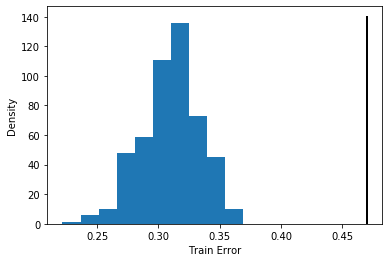

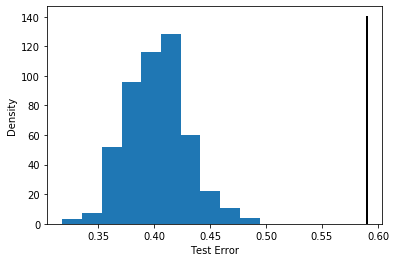

In [59]:
# histograms of the errors and the baseline of tenure vs no tenure. 
plt.hist(output[0])
plt.xlabel("Train Error")
plt.ylabel("Density")
l1 = plt.plot([0.47,0.47], [0, 140], 'k-', lw=2)
plt.figure(0)
plt.hist(output[2],stacked=True)
plt.xlabel("Test Error")
plt.ylabel("Density")
l1 = plt.plot([0.59,0.59], [0, 140], 'k-', lw=2) 

In [22]:
#calculating the baseline values for the above plots
X_train, X_test, y_train, y_test = train_test_split(X,titles,test_size=0.2,random_state=42)
train_df = pd.DataFrame(y_train)
test_df = pd.DataFrame(y_test)
train_df['title'].value_counts().max()
most_pop_train = train_df['title'].value_counts().max()
baseline_train = 1-(most_pop_train/len(train_df))
most_pop_test = test_df['title'].value_counts().max()
baseline_test = 1- (most_pop_test/len(test_df))

print(baseline_train)
print(baseline_test)
test_df['title'].value_counts()

0.4733096085409253
0.5915492957746479


0    29
3    26
2    11
1     5
Name: title, dtype: int64